Purpose: Problem set 2 code for question 3 

Created: Nico Rotundo 2024-11-15

Import packages and data

In [7]:
# Set backend ecplicitly for inline plotting
%matplotlib inline

# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr


# Load the data
data = pd.read_csv('/Users/nicorotundo/Library/CloudStorage/Box-Box/econ_240a/data/RPS_calorie_data.out', usecols=['Y0tc', 'X0te']) 

# Log calories
Y = data['Y0tc'].values  

# Log expenditure
X = data['X0te'].values  

# Browse first 5 rows
print(data.head())

# Summary statistics
print(data.describe())

       Y0tc      X0te
0  9.061790  9.917698
1  7.870896  8.276105
2  8.262976  8.036979
3  9.057076  9.212327
4  8.953918  9.826068
              Y0tc         X0te
count  1358.000000  1358.000000
mean      9.171361     9.841209
std       0.656817     0.627751
min       5.724353     7.358163
25%       8.804419     9.431400
50%       9.221832     9.860188
75%       9.612586    10.284695
max      10.837850    11.656190


Question 1: Define the power series basis described as,
$m(x) = \mathbb{E}[Y|X=x] = \sum_{k=1}^{k}\alpha_k g_k (x)$ where $g_k(x) = x^{k-1}$ ; set K = 12

 

In [8]:
# Set K = 12 
K = 12 

# Define the power series basis functions
def power_basis(x, K):

    # Normalize
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    
    # Returns a matrix where each column is x^(k-1) for k=1 to K
    return np.vstack([x**(k-1) for k in range(1, K+1)]).T

# Generate the basis matrix for X (log expenditure)
G = power_basis(X, K)

# View the first few rows of the power series basis matrix to verify
print(pd.DataFrame(G).head())

    0         1         2         3         4         5         6         7   \
0  1.0  0.595514  0.354637  0.211191  0.125767  0.074896  0.044602  0.026561   
1  1.0  0.213573  0.045613  0.009742  0.002081  0.000444  0.000095  0.000020   
2  1.0  0.157937  0.024944  0.003940  0.000622  0.000098  0.000016  0.000002   
3  1.0  0.431399  0.186105  0.080285  0.034635  0.014942  0.006446  0.002781   
4  1.0  0.574195  0.329700  0.189312  0.108702  0.062416  0.035839  0.020579   

             8             9             10            11  
0  1.581741e-02  9.419490e-03  5.609438e-03  3.340498e-03  
1  4.328813e-06  9.245170e-07  1.974518e-07  4.217034e-08  
2  3.871359e-07  6.114295e-08  9.656713e-09  1.525149e-09  
3  1.199588e-03  5.175008e-04  2.232493e-04  9.630948e-05  
4  1.181611e-02  6.784747e-03  3.895767e-03  2.236929e-03  


### Question 2
Using the power series basis described above and the Gram-Schmidt algorithm, construct a new basis that is orthogonal to the design points (set $K = 12$). Let $W_i$ denote the $K \times 1$ vector of orthonormal basis functions for the $i$th household. 

i. Compute the least squares fit

$$
m(X_i) = W_i' \hat{\theta}
$$

with

$$
\hat{\theta} = \left( \sum_{i=1}^N W_i W_i' \right)^{-1} \times \left( \sum_{i=1}^N W_i Y_i \right).
$$

ii. Plot this function onto a scatter of the unsmoothed data.

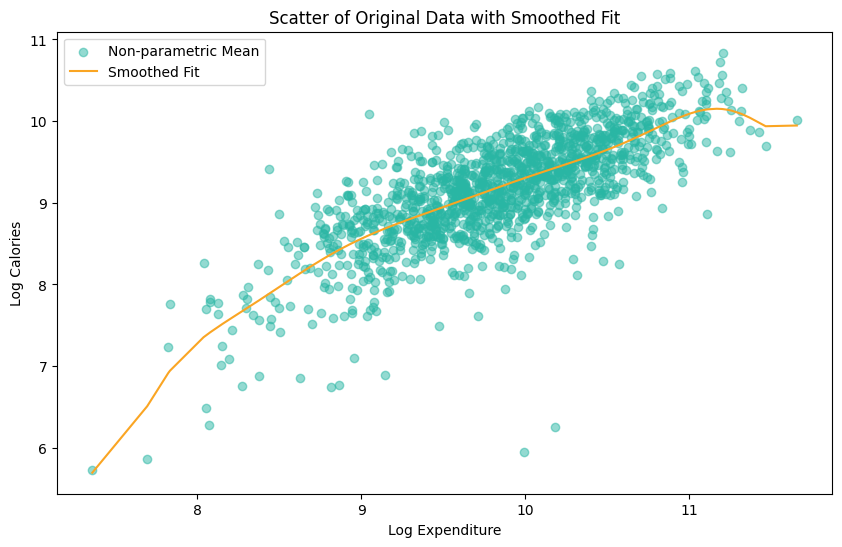

In [9]:
# Define projection function
def proj(f, g):
    
    # Orthogonal projection of g onto f
    return (np.dot(f, g) / np.dot(f, f)) * f

# Define Gram-Schmidt orthogonalization function
def GramSchmidt(G):
    
    # Perform Gram-Schmidt orthogonalization on matrix G to create an orthonormal basis
    G = np.array(G, dtype=float)
    F = np.copy(G)
    
    # Orthogonalize the design matrix
    for i in range(1, G.shape[1]):
        for j in range(i):
            F[:, i] -= proj(F[:, j], G[:, i])
    
    # Normalize each column to have unit length
    norm_F = (F**2).mean(axis=0)**0.5
    W = F / norm_F
    return W

# Apply Gram-Schmidt to get orthonormal basis W
W = GramSchmidt(G)

# Calculate theta_hat using the least squares formula
theta_hat = np.linalg.inv(W.T @ W) @ W.T @ Y

# Calculate the fitted values m(X_i) = W_i' * theta_hat
m_X = W @ theta_hat

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, color = (41/255, 182/255, 164/255), label='Non-parametric Mean', alpha=0.5)
plt.plot(np.sort(X), m_X[np.argsort(X)], color= (250/255, 165/255, 35/255), label='Smoothed Fit')
plt.xlabel('Log Expenditure')
plt.ylabel('Log Calories')
plt.legend()
plt.title('Scatter of Original Data with Smoothed Fit')
plt.show()  

plt.close()

Question 3: Now use the shrinkage estimator of Efromovich (1999) as described in lecture to estimate m (Xi). 

i. Plot this function onto a scatter of the unsmoothed data. 

ii. Comment on your findings.

    - The shrinkage estimator results in a smoother plot than the least squares estimator, since the shrinkage reduces the variance 

Original Coefficients (Least Squares): [9.24847098 7.67604404 7.35290045 ... 9.50626625 9.71701617 9.27081832]
Soft Threshold Coefficients: [9.2483309  7.67592778 7.35278908 ... 9.50612227 9.716869   9.2706779 ]


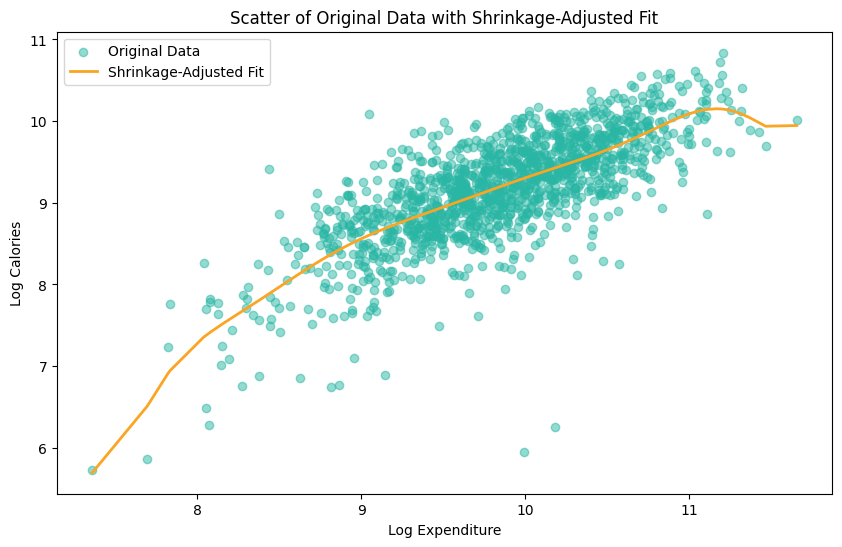

In [10]:
# Step 1: Calculate MLE of sigma^2
N = len(Y)  # Number of observations
sigma2 = np.sum((Y - m_X) ** 2) / (N - K)

# Step 2: Shrink the coefficients
shrinkage_coefficients = []
for k, theta_k in enumerate(theta_hat):
    shrinkage_factor = max(1 - (sigma2 / N) / (theta_k ** 2), 0)
    shrinkage_coefficients.append(shrinkage_factor * theta_k)

# Convert to numpy array for vectorized calculations
#shrinkage_coefficients = np.array(shrinkage_coefficients)

# Step 4: Calculate the shrinkage-adjusted fit
m_EF_X = W @ (shrinkage_factor*theta_hat)

# Debugging: Print the coefficients to ensure they differ
print("Original Coefficients (Least Squares):", m_X)
print("Soft Threshold Coefficients:", m_EF_X)

# Step 5: Plot the original data and the shrinkage-adjusted fit only
plt.figure(figsize=(10, 6))

# Scatter plot for original data
plt.scatter(X, Y, color=(41/255, 182/255, 164/255), label='Original Data', alpha=0.5)

# Shrinkage-adjusted fit
plt.plot(np.sort(X), m_EF_X[np.argsort(X)], color=(250/255, 165/255, 35/255), linestyle='-', linewidth=2, label='Shrinkage-Adjusted Fit')

# Add labels, title, and legend
plt.xlabel('Log Expenditure')
plt.ylabel('Log Calories')
plt.legend()
plt.title('Scatter of Original Data with Shrinkage-Adjusted Fit')

# Show the plot
plt.show()
plt.close()

 Question 4: Now compute the soft threshold estimate of m (Xi) (as defined above). Plot this function onto a scatter of the unsmoothed data.

In [11]:
# Step 1: Define the risk function R(lambda)
def risk_function(lambda_val, theta_hat, sigma_squared, N, K):
    # Compute the risk for a given lambda
    term1 = (K / N) * sigma_squared
    term2 = - (2 * sigma_squared / N) * np.sum(np.abs(theta_hat) <= lambda_val)
    term3 = np.sum(np.minimum(theta_hat**2, lambda_val**2))
    return term1 + term2 + term3

# Step 2: Minimize R(lambda) over a range of lambda values
lambda_values = np.linspace(0, max(np.abs(theta_hat)), 100)  # Range of lambda
risks = [risk_function(lmb, theta_hat, sigma_squared, N, K) for lmb in lambda_values]
optimal_lambda = lambda_values[np.argmin(risks)]  # Choose lambda that minimizes the risk

# Step 3: Compute the soft threshold-adjusted coefficients
def soft_threshold(theta_hat, lambda_val):
    # Apply the soft thresholding operator to the coefficients.
    return np.sign(theta_hat) * np.maximum(np.abs(theta_hat) - lambda_val, 0)

theta_hat_sft = soft_threshold(theta_hat, optimal_lambda)

# Step 4: Calculate the soft threshold estimate m_SFT(X)
m_SFT_X = W @ theta_hat_sft

# Plot the original data and the soft threshold estimate
plt.figure(figsize=(10, 6))

# Scatter plot of original data
plt.scatter(X, Y, color=(41/255, 182/255, 164/255), label='Original Data', alpha=0.5)

# Soft threshold estimate fit
plt.plot(np.sort(X), m_SFT_X[np.argsort(X)], color=(250/255, 165/255, 35/255), linestyle='-', linewidth=2, label='Soft Threshold Fit')

# Add labels, title, and legend
plt.xlabel('Log Expenditure')
plt.ylabel('Log Calories')
plt.legend()
plt.title('Scatter of Original Data with Soft Threshold Fit')

# Show the plot
plt.show()

NameError: name 'sigma_squared' is not defined